In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
#from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
from model import MambaFull, generate_data, seq2seq_generate_tour, compute_tour_length
from datetime import datetime

# Define model parameters and hyperparameters
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

args=DotDict() 

#Args for the model
args.bsz=600
args.d_model = 64 #ensure that this is a multiple of 2
args.coord_dim = 2
args.nb_layers = 3
args.mlp_cls = nn.Identity #if set as None will use a linear layer
args.city_count = 5
args.deterministic = False #used for sampling from the model
args.fourier_scale = None #If set as None a standard Linear map is used else a gaussian fourier feature mapping is used
#args.polar = True #TODO

#Args for the training
args.nb_epochs=300
args.test_size=2000
args.nb_batch_per_epoch=10
args.save_loc = 'mamba/checkpoints/embed/Linear3'
args.test_data_loc=f'mamba/data/start_2/test_rand_{args.test_size}_{args.city_count}_{args.coord_dim}.pt'
#0 => data will not be recycled and each step new data is generated, however this will make the gpu spend most of the time loading data. Recommeded val is 100
args.recycle_data=0

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if args.fourier_scale is None:
    B = None
else:
    B = torch.randn(args.d_model // 2, 2).to(device) * args.fourier_scale

#model which will be train and baseline as in the REINFORCE algorithm. 
model_train = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls, B = B).to(device)
model_baseline = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls, B = B).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_train.parameters(), lr=1e-4)


checkpoint=None
#checkpoint = torch.load('mamba/checkpoints/embed/Linear_17-06_13-24.pt') #Highlight out if no chekpoint is available
if checkpoint:
    model_train.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    tot_time_ckpt = checkpoint['time_tot']
    start_epoch = checkpoint['epoch']
    mean_tour_length_list = checkpoint['mean_tour_length_list']
    mean_tour_length_best = checkpoint['mean_tour_length_list'][-1]
else:
    tot_time_ckpt, start_epoch = 0,0
    mean_tour_length_list = [] 
    mean_tour_length_best = float('inf') 

model_baseline.load_state_dict(model_train.state_dict())
model_baseline.eval()
for name, param in model_train.named_parameters():
    print(f"Parameter: {name}, Size: {param.size()}")
total_params = sum(p.numel() for p in model_train.parameters())
print(f"Total number of parameters: {total_params}")

TypeError: Linear.__init__() missing 1 required positional argument: 'out_features'

In [3]:

test_data = torch.load(args.test_data_loc).to(device)
test_data_batches = torch.split(test_data, args.bsz)

print(test_data.shape)
print([x.shape for x in test_data_batches])

start_training_time = time.time()
now = datetime.now()
date_time = now.strftime("%d-%m_%H-%M")

# Training loop
for epoch in tqdm(range(start_epoch,args.nb_epochs)):
    model_train.train()
    i= 0 # Tracks the number of steps before we generate new data
    start = time.time()
    for step in range(args.nb_batch_per_epoch):

        if i == 0:
            #Inputs will have size (bsz, seq_len, coord_dim)
            inputs = generate_data(device, args.bsz, args.city_count, args.coord_dim)
            i=args.recycle_data
        else: i-=1

        # list that will contain Long tensors of shape (bsz,) that gives the idx of the cities chosen at time t
        tours_train, sumLogProbOfActions = seq2seq_generate_tour(device,model_train,inputs,args.deterministic)
        tours_baseline, _ = seq2seq_generate_tour(device,model_baseline,inputs,args.deterministic)
        #get the length of the tours
        with torch.no_grad():
            L_train = compute_tour_length(inputs, tours_train)
            L_baseline = compute_tour_length(inputs, tours_baseline)
        #print(f"L_train requires_grad: {L_train.requires_grad}")

        # backprop     
        loss = torch.mean( (L_train - L_baseline)* sumLogProbOfActions )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    time_one_epoch = time.time()-start
    time_tot = time.time()-start_training_time + tot_time_ckpt

    ###################
    # Evaluate train model and baseline
    ###################
    model_train.eval()
    L_train_total = 0
    L_baseline_total = 0
    
    # Compute tour for model and baseline for test data, making it sure its split to not overload the gpu
    for test_data_batch in test_data_batches:
        tour_train, _ = seq2seq_generate_tour(device, model_train, test_data_batch, deterministic=True)
        tour_baseline, _ = seq2seq_generate_tour(device, model_baseline, test_data_batch, deterministic=True)

        # Get the lengths of the tours and add to the accumulators
        L_train_total += compute_tour_length(test_data_batch, tour_train).sum()
        L_baseline_total += compute_tour_length(test_data_batch, tour_baseline).sum()

    # Compute the average tour lengths
    L_train = L_train_total / args.test_size
    L_baseline = L_baseline_total / args.test_size

    print(f'Epoch {epoch}, test tour length train: {L_train}, test tour length baseline: {L_baseline}, time one epoch: {time_one_epoch}, time tot: {time_tot}')

    mean_tour_length_list.append(L_train)
    # evaluate train model and baseline and update if train model is better
    if L_train < L_baseline:
        model_baseline.load_state_dict( model_train.state_dict() )

    # Save checkpoint every 10,000 epochs
    if L_train < mean_tour_length_best:
        mean_tour_length_best = L_train

        # Append to filename
        filename = f"file_{date_time}.pt"
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_train.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'mean_tour_length_list': mean_tour_length_list,
            'args': args,
            'time_tot': time_tot
        }
        torch.save(checkpoint, f'{args.save_loc}_{date_time}.pt' )

torch.Size([2000, 6, 2])
[torch.Size([600, 6, 2]), torch.Size([600, 6, 2]), torch.Size([600, 6, 2]), torch.Size([200, 6, 2])]


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0, test tour length train: 2.609821319580078, test tour length baseline: 2.609821319580078, time one epoch: 12.814937114715576, time tot: 12.826230764389038
Epoch 1, test tour length train: 2.609821319580078, test tour length baseline: 2.609821319580078, time one epoch: 7.3854615688323975, time tot: 21.381329774856567
Epoch 2, test tour length train: 2.606642246246338, test tour length baseline: 2.609821319580078, time one epoch: 7.411854267120361, time tot: 29.948365688323975
Epoch 3, test tour length train: 2.602680206298828, test tour length baseline: 2.606642246246338, time one epoch: 7.439724445343018, time tot: 38.56156849861145
Epoch 4, test tour length train: 2.607285976409912, test tour length baseline: 2.602680206298828, time one epoch: 7.469849348068237, time tot: 47.21273851394653
Epoch 5, test tour length train: 2.6167144775390625, test tour length baseline: 2.602680206298828, time one epoch: 7.476102590560913, time tot: 55.8512225151062
Epoch 6, test tour length tra

{'bsz': 600, 'd_model': 64, 'coord_dim': 2, 'nb_layers': 3, 'mlp_cls': <class 'torch.nn.modules.linear.Identity'>, 'city_count': 5, 'deterministic': False, 'fourier_scale': None, 'nb_epochs': 300, 'test_size': 2000, 'nb_batch_per_epoch': 10, 'save_loc': 'mamba/checkpoints/embed/Linear_cont', 'test_data_loc': 'mamba/data/start_2/test_rand_2000_5_2.pt', 'recycle_data': 0}
296
2589.49747467041


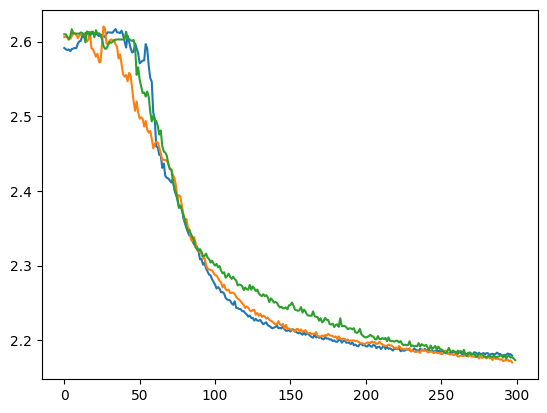

In [7]:
checkpoint = torch.load('mamba/checkpoints/embed/Linear1_18-06_12-34.pt')
print(checkpoint['args'])
checkpoint2 = torch.load('mamba/checkpoints/embed/Linear2_18-06_12-57.pt')
checkpoint3 = torch.load('mamba/checkpoints/embed/Linear3_18-06_13-49.pt')
model_train.load_state_dict(checkpoint2['model_state_dict'])
model_train.eval()
mean_tour_length_list = [tensor.cpu().numpy() for tensor in checkpoint['mean_tour_length_list']]
mean_tour_length_list2 = [tensor.cpu().numpy() for tensor in checkpoint2['mean_tour_length_list']]
mean_tour_length_list3 = [tensor.cpu().numpy() for tensor in checkpoint3['mean_tour_length_list']]
print(checkpoint['epoch'])
print(checkpoint['time_tot'])
plt.plot(mean_tour_length_list)
plt.plot(mean_tour_length_list2)
plt.plot(mean_tour_length_list3)
plt.show()


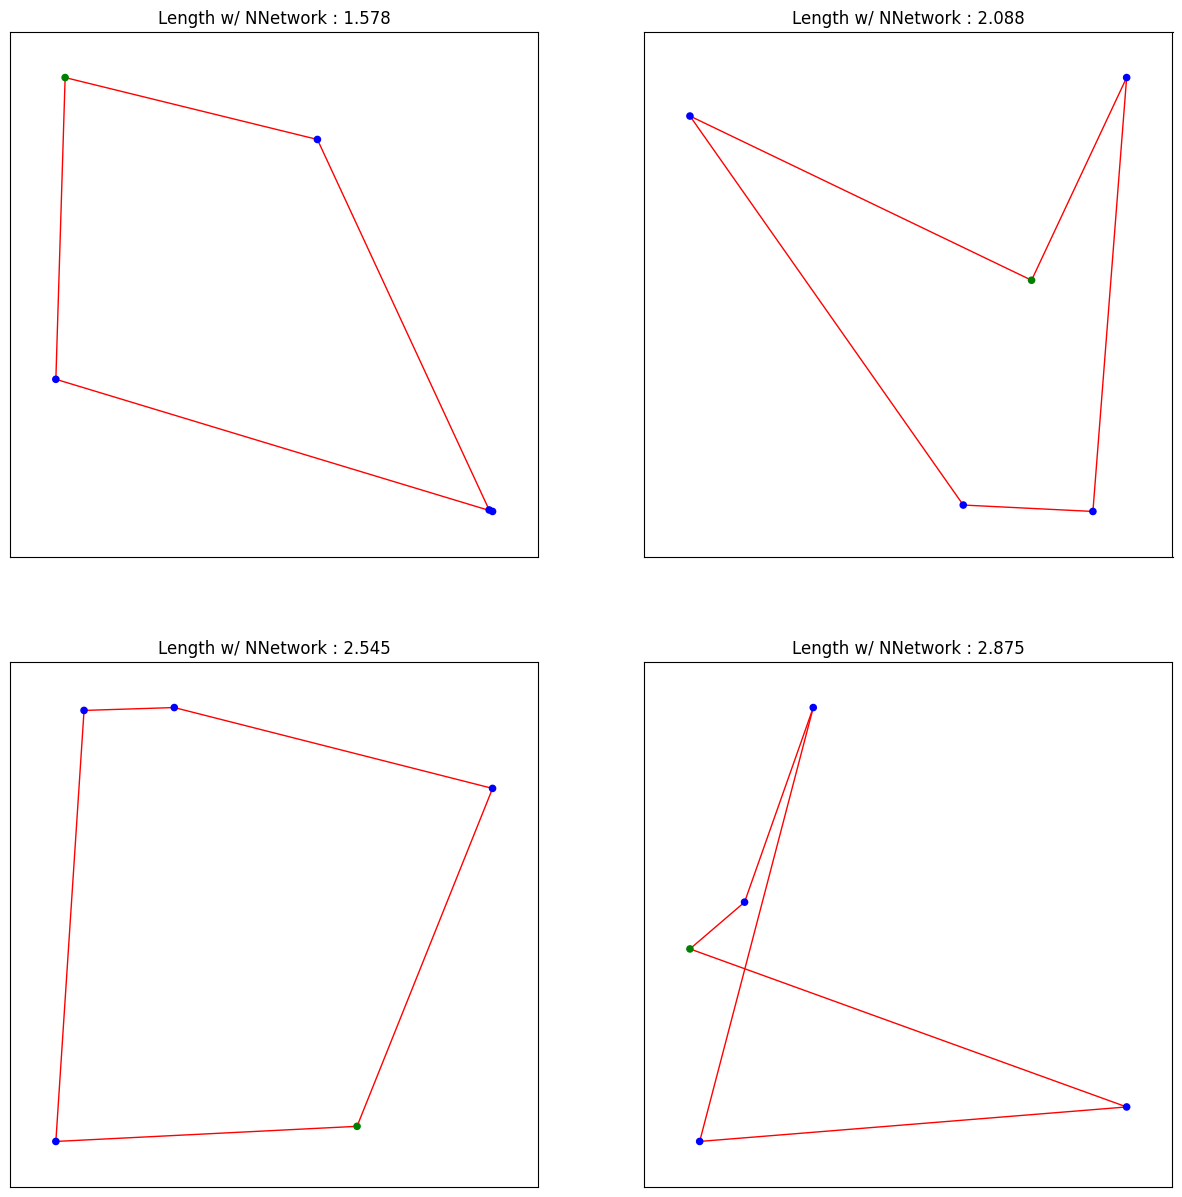

In [5]:
from model import plot_tsp
x = generate_data(device, 4, args.city_count, args.coord_dim)
tour, _ = seq2seq_generate_tour(device,model_train,x,deterministic=True)
plot_tsp(x,tour)